# Let's generate some data from a state space model

In [1]:
using Distributions
using PyPlot
srand(12346)  # set random number seed

INFO: Loading help data...


We'll generate data according to a simple state space model and then recover the underlying model via the Kalman filter/smoother. We follow the conventions of [Durbin and Koopman (2012)](http://www.ssfpack.com/DKbook.html).

## Observation model

$$\begin{align}
y_t &= Z_t \alpha_t + \varepsilon_t \\
\varepsilon_t &\sim \mathcal{N}(0, H_t)
\end{align}$$

In [2]:
Z = [1 -1 ; 0 1 ; 1 0]
H = [1 0 0 ; 0 1 0.2 ; 0 0.2 1]

Np, Nm = size(Z);

In [3]:
assert(size(H) == (Np, Np))

## State evolution model

$$
\begin{align}
\alpha_{t+1} &= T_t \alpha_t + R_t \eta_t \\
\eta_t &\sim \mathcal{N}(0, Q_t)
\end{align}$$

In [4]:
th = 10 * pi / 180
T = [cos(th) sin(th) ; -sin(th) cos(th)]
R = [1.1 1]'
Q = [0.05]

_, Nr = size(R);

In [5]:
assert(size(T) == (Nm, Nm))

## Prior
$$
\alpha_1 \sim \mathcal{N}(a_1, P_1)
$$

In [6]:
a_init = zeros(Nm)
P_init = 5 * eye(Nm);

In [7]:
assert(size(P_init) == (Nm, Nm))

# Now generate some data

In [8]:
Nt = 100  # number of samples

100

In [9]:
# preallocate
α = Array(Float64, Nm, Nt);
y = Array(Float64, Np, Nt);
ϵ = Array(Float64, Np, Nt);
η = Array(Float64, Nr, Nt);

Initialize:

In [10]:
α[:, 1] = rand(MvNormal(a_init, P_init));

In [11]:
ϵrng = MvNormal(H)
ηrng = MvNormal(Q)
for t in 1:Nt
    ϵ[:, t] = rand(ϵrng)
    η[:, t] = rand(ηrng)
    
    y[:, t] = Z * α[:, t] + ϵ[:, t]
    
    if t + 1 <= Nt
        α[:, t + 1] = T * α[:, t] + R * η[:, t]
    end
end

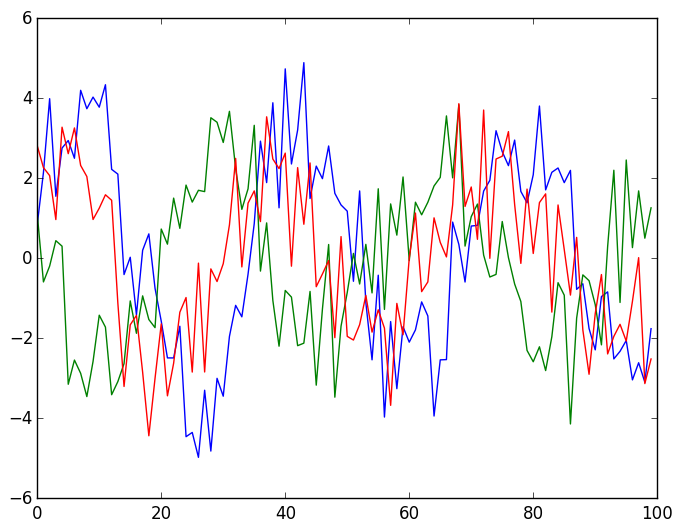

In [12]:
plot(y');

# Kalman filter (forward)

Now filter! In DK conventions, this is
$$\begin{align}
v_t &= y_t - Z_t a_t  \\
F_t &= Z_t P_t Z_t^\top + H_t  \\
aa \equiv \mathbb{E}(\alpha_t\vert y_{1:t}) &= a_t + P_t Z_t^\top F_t^{-1} v_t  \\
PP \equiv \mathrm{var}(\alpha_t \vert y_{1:t}) &= P_t - P_t Z_t^\top F_t^{-1} Z_t P_t  \\
K_t &= T_t P_t Z_t^\top F_t^{-1}  \\
L_t &= T_t - K_t Z_t  \\
a_{t + 1} &= T_t a_t + K_t v_t  \\
P_{t + 1} &= T_t P_t(T_t - K_t Z_t)^\top + R_t Q_t R_t^\top
\end{align}$$

In [13]:
#preallocate

a = Array(Float64, Nm, Nt);
P = Array(Float64, Nm, Nm, Nt);
aa = Array(Float64, Nm, Nt);
PP = Array(Float64, Nm, Nm, Nt);
v = Array(Float64, Np, Nt);
F = Array(Float64, Np, Np, Nt);
K = Array(Float64, Nm, Np, Nt);
L = Array(Float64, Nm, Nm, Nt);

In [14]:
# set priors
a[:, 1] = a_init;
P[:, :, 1] = P_init;

In [15]:
# iterate

for t in 1:Nt
    v[:, t] = y[:, t] - Z * a[:, t]
    Ft = Z * P[:, :, t] * Z' + H
    F[:, :, t] = Ft
    Finv = inv(Ft)
    aa[:, t] = a[:, t] + P[:, :, t] * Z' * Finv * v[:, t]
    PP[:, :, t] = P[:, :, t] - P[:, :, t] * Z' * Finv * Z * P[:, :, t]
    K[:, :, t] = T * P[:, :, t] * Z' * Finv
    L[:, :, t] = T - K[:, :, t] * Z
    
    if t < Nt
        a[:, t + 1] = T * a[:, t] + K[:, :, t] * v[:, t]
        P[:, :, t + 1] = T * P[:, :, t] * L[:, : , t]' + R * Q * R'
    end
    
end

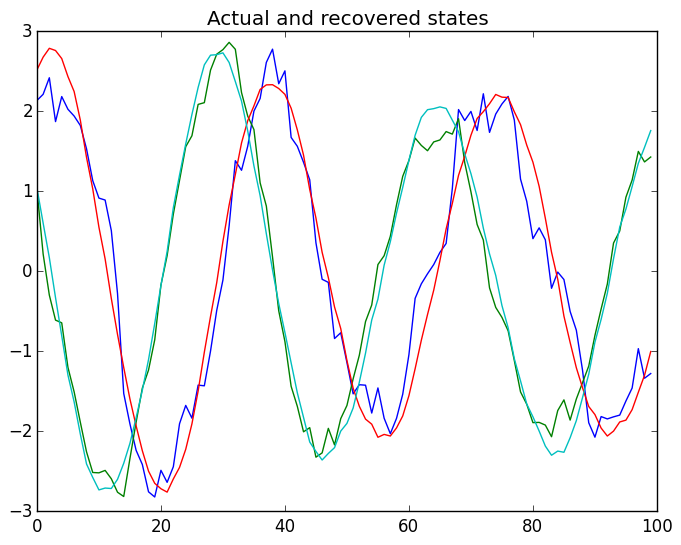

In [16]:
plot(aa')
plot(α')
title("Actual and recovered states");

# Kalman smoother (backward)

First define the posterior of the state vector given all the data as
$$\begin{align}
p(\alpha_t \vert y_{1:N}) = \mathcal{N}(\hat{\alpha}_t, V_t) 
\end{align}$$

The recursions for the smoothed state $\hat{\alpha}$ are then

$$\begin{align}
r_n &= 0  \\
N_n &= 0  \\
r_{t - 1} &= Z_t^\top F_t^{-1} v_t + L_t^\top r_t  \\
N_{t - 1} &= Z_t^\top F_t^{-1} Z_t + L_t^\top N_t L_t  \\
\hat{\alpha}_t &= a_t + P_t r_{t - 1}  \\
V_t &= P_t - P_t N_{t - 1} P_t
\end{align}$$

In [17]:
r = Array(Float64, Nm, Nt)
ahat = Array(Float64, Nm, Nt)
N = Array(Float64, Nm, Nm, Nt)
V = Array(Float64, Nm, Nm, Nt)

ahat[:, 1] = a_init
V[:, :, 1] = P_init
r[:, end] = 0
N[:, :, end] = 0;

In [18]:
for t in Nt:-1:2

    local F_t = F[:, :, t]
    local Finv = inv(F_t)
    local r_t = r[:, t]
    local v_t = v[:, t]
    local L_t = L[:, :, t]
    local N_t = N[:, :, t]
    local a_t = a[:, t]
    local P_t = P[:, :, t]
    
    r[:, t - 1] = Z' * Finv * v_t + L_t' * r_t
    N[:, :, t - 1] = Z' * Finv * Z + L_t' * N_t * L_t
    
    ahat[:, t] = a_t + P_t * r[:, t - 1]
    V[:, :, t] = P_t - P_t * N[:, :, t - 1] * P_t
end

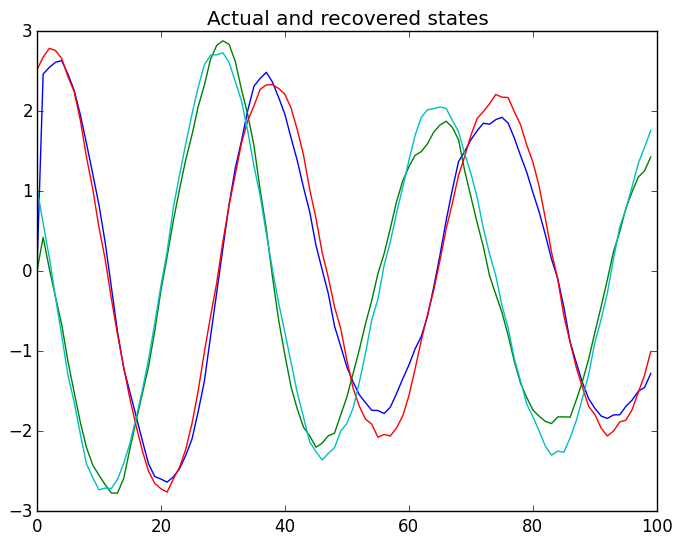

In [19]:
plot(ahat')
plot(α')
title("Actual and recovered states");

# Disturbance smoother/fast state smoother

As an alternative to the Kalman smoother, Durbin and Koopman recommend a disturbance smoother for the noise terms $\varepsilon$ and $\eta$. This recursion has lower memory requirements (using only $v_t$, $F_t$, and $K_t$) and does not require multiplication by the often dense $a_t$ and $P_t$. 

This system of recursions (for the posterior means) is given by

$$\begin{align}
u_t &= F_t^{-1} v_t - K_t^\top r_t  \\
\hat{\varepsilon}_t &= H_t u_t  \\
\hat{\eta}_t &= Q_t R_t^\top r_t  \\
r_{t - 1} &= Z_t^\top u_t + T_t^\top r_t
\end{align}$$

with additional recursions for the variances (cf. Durbin and Koopman 4.5.3).

These recursions provide a particularly efficient means of calculating the smoothed state estimates $\hat{\alpha}_t$:

$$\begin{align}
\hat{\alpha}_1 &= a_1 + P_1 r_0  \\
\hat{\alpha}_{t + 1} &= T_t \hat{\alpha}_t + R_t Q_t R_t^\top r_t
\end{align}$$

This takes advantage of the typical sparsity of $T$ and $RQR$. However, it does not lend itself to calculating the posterior smoothed variances $V$.

Thus, if we only care about the posterior smoothed state means, we can do so very efficiently by saving only $F$, $K$,  and $v$ from the filtering step, calculate $r$ from the recursion using $u$ above, and run the model forward in time to get $\hat{\alpha}$.

## Implementation of the fast state smoother

First, we initialize $r$ and $\hat{\alpha}$:

In [20]:
# initialize r
r = Array(Float64, Nm, Nt)
r[:, end] = 0
alphat = Array(Float64, Nm, Nt);

Then we recursively calculate $r$, working backward in time:

In [21]:
# calculate r
r_init = 1.

for t in Nt:-1:1
    local Finv = inv(F[:, :, t])
    local v_t = v[:, t]
    local K_t = K[:, :, t]
    local r_t = r[:, t]
    
    local u = Finv * v_t - K_t' * r_t
    local thisr = Z' * u + T' * r_t
    
    if t - 1 > 0
        r[:, t - 1] = thisr
    else
        r_init = thisr
    end
end

Finally, we run the state space model forward in time

In [22]:
# run model forward
alphat[:, 1] = a_init + P_init * r_init
RQR = R * Q * R'

for t in 1:(Nt - 1)
    alphat[:, t + 1] = T * alphat[:, t] + RQR * r[:, t]
end

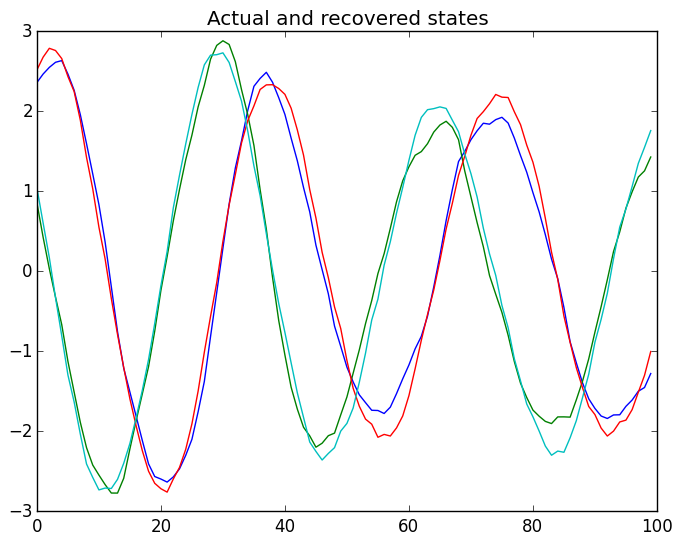

In [23]:
plot(alphat')
plot(α')
title("Actual and recovered states");

# Drawing posterior samples (simulation smoothing)

We want to be able to sample from the smoothed posterior for the states, $p(\alpha_t|y_{1:N})$. We can do this using the technique of [Durbin and Koopman (2002)](http://biomet.oxfordjournals.org/content/89/3/603.short), which involves following steps:

1. Draw disturbance terms ($\varepsilon$ and $\eta$) from the *prior*, denoted $w^+$.
1. Simulate the model using these disturbances, generating a state sequence, $\alpha^+$ and observations $y^+$.
1. Using the Kalman filter and smoother, calculate smoothed estimates of the state sequence conditioned
    on the actual and the simulated data, $\hat{\alpha} = \mathbb{E}(\alpha|y_{1:n})$ and 
    $\hat{\alpha}^+ = \mathbb{E}(\alpha|y^+_{1:n})$.
1. Combine these estimates with the simulated state sequence. The result, 
    $\alpha^+ - \hat{\alpha}^+ + \hat{\alpha}$, is a draw from the posterior.

## Implementing the posterior sampler

In [24]:
# preallocate

alpha_plus = Array(Float64, Nm, Nt)
y_plus = Array(Float64, Np, Nt);

## Draw Disturbances

In [25]:
ϵ_sim = rand(MvNormal(H), Nt)
η_sim = rand(MvNormal(Q), Nt);

## Simulate model

In [26]:
alpha_plus[:, 1] = rand(MvNormal(a_init, P_init))
for t in 1:Nt
    y_plus[:, t] = Z * alpha_plus[:, t] + ϵ_sim[:, t] 
    if t < Nt
        alpha_plus[:, t + 1] = T * alpha_plus[:, t] + R * η_sim[:, t]
    end
end

## Get Smoothed Means

Now run the data through...

In [27]:
import SStools

In [28]:
vv, KK, FFinv = SStools.kalman_filter(y, a_init, P_init, Z, H, T, R, Q)
alpha_hat = SStools.fast_state_smoother(vv, KK, FFinv, a_init, P_init, Z, T, R, Q)

2x100 Array{Float64,2}:
 2.36173  2.46769   2.5508     2.61449   …  -1.4974   -1.4507   -1.27623
 0.85629  0.426936  0.034183  -0.321544      1.18006   1.25765   1.43049

In [29]:
vv, KK, FFinv = SStools.kalman_filter(y_plus, a_init, P_init, Z, H, T, R, Q)
alpha_hat_plus = SStools.fast_state_smoother(vv, KK, FFinv, a_init, P_init, Z, T, R, Q)

2x100 Array{Float64,2}:
 0.449328  0.99297  1.38883  1.72905  …  -2.95319  -3.1904    -3.39718 
 2.76516   2.70904  2.44138  2.1062      -1.31449  -0.830632  -0.364916

## And Combine

In [30]:
alpha_draw = alpha_plus - alpha_hat_plus + alpha_hat

2x100 Array{Float64,2}:
 2.36112   2.36949    2.45766   2.5522    …  -1.64016  -1.52691  -1.24767
 0.733433  0.236722  -0.10282  -0.391907      1.06976   1.24975   1.53138

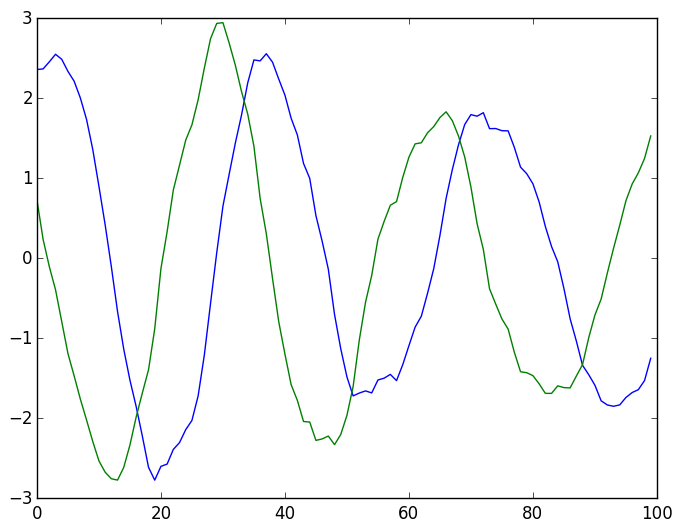

In [31]:
plot(alpha_draw');

And we can do this with a single function:

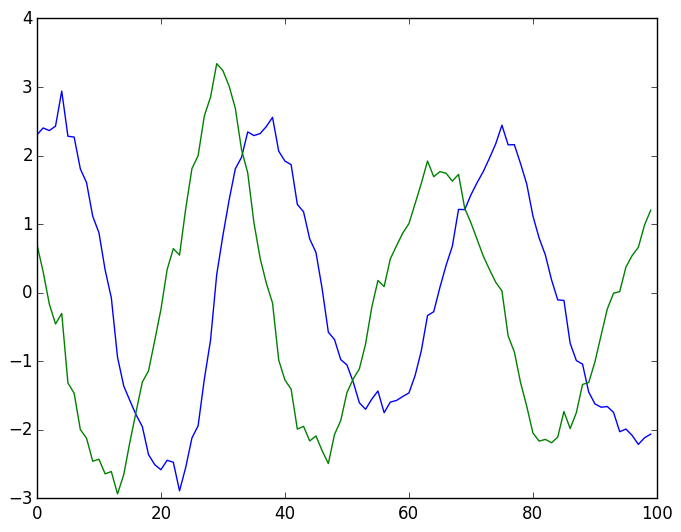

In [32]:
adraw = SStools.simulate(y, a_init, P_init, Z, H, T, R, Q)
plt.plot(adraw');

# Let's make a posterior

In [33]:
Ns = 1000  # number of samples

alpha_samples = Array(Float64, Nm, Nt, Ns);

In [34]:
for idx in 1:Ns
    alpha_samples[:, :, idx] = SStools.simulate(y, a_init, P_init, Z, H, T, R, Q)
end

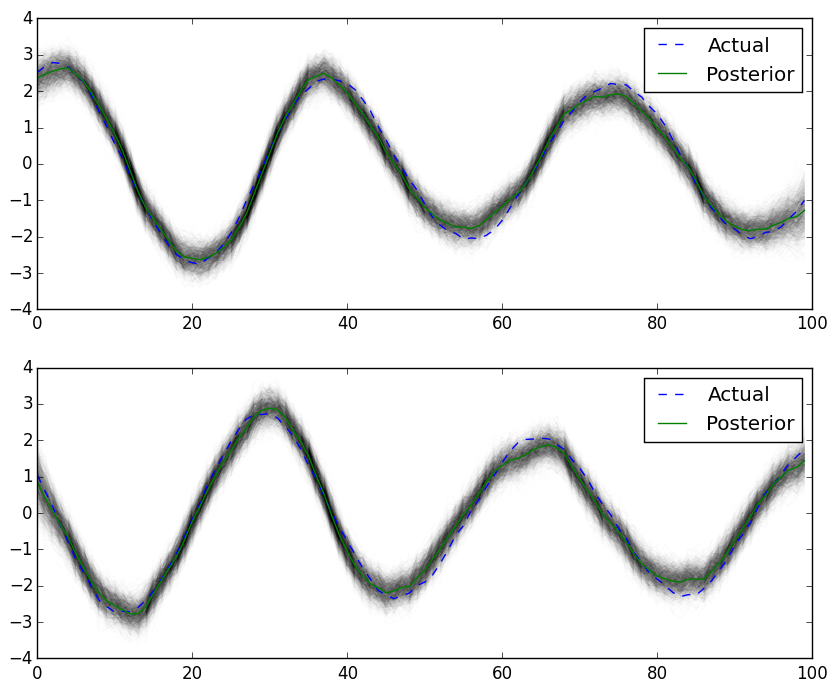

In [41]:
trans = 10 / Ns
figure(figsize=(10, 8))

for idx in 1:Nm
    subplot(Nm, 1, idx)
    plot(squeeze(alpha_samples[idx, :, :], 1), color="black", alpha=trans)
    plot(α[idx, :]', linestyle="--", label="Actual")
    plot(alphat[idx, :]', label="Posterior")
    legend()
end